# Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels import robust
from researchpy import ttest
import matplotlib as mpl
import numpy as np

In [2]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 125
sns.set(rc={'figure.figsize':(8,6)})
#plt.rcParams["font.size"] = 10
#par = {'axes.titlesize':16}
#plt.rcParams.update(par)
# sns.set_theme(style='whitegrid', rc={'grid.linestyle':(0, (5, 10))})
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(['#55617C', '#E2B7AB']))

In [3]:
# Get list of csvs in target directory
csvs_list = os.listdir('../data/Divvy')

# Complete path for file for pd.concat
csvs_to_merge = []
for i in csvs_list:
    i = '../data/Divvy/'+i
    csvs_to_merge.append(i)

In [4]:
# Join all csvs into time-series dataframe for cleaning. 
# At this point either clean in SQL or Python

df = pd.concat(map(pd.read_csv, csvs_to_merge), ignore_index=True)

In [5]:
# Check types to make sure they're imported properly

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5858018 entries, 0 to 5858017
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 581.0+ MB


In [6]:
# Convert date columns to dates from objects.

for i in ['started_at', 'ended_at']:
    df[i] = pd.to_datetime(df[i], infer_datetime_format=True)

In [7]:
# Reduce memory usage by converting certain fields to categorical rather than objects.

categoricals = ['start_station_name', 'start_station_id', 
                'end_station_name' , 'end_station_id', 'member_casual']

for i in categoricals:
    df[i] = df[i].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5858018 entries, 0 to 5858017
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   start_station_id    category      
 6   end_station_name    category      
 7   end_station_id      category      
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
dtypes: category(5), datetime64[ns](2), float64(4), object(2)
memory usage: 408.1+ MB


In [8]:
# Process time-related data. Get useful things like day of week, month, year, etc.

df['ride_time_mins'] = (df['ended_at'] - df['started_at']) / pd.Timedelta(minutes=1)
df['year'] = df['started_at'].dt.year
df['month'] = df['started_at'].dt.month
df['day_of_week'] = df['started_at'].dt.dayofweek

In [9]:
df['weekday_weekend'] = df['day_of_week'].apply(lambda x: 'weekend' if x == 6 | 0 else 'weekday')
df['weekday_weekend'] = df['weekday_weekend'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5858018 entries, 0 to 5858017
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   start_station_id    category      
 6   end_station_name    category      
 7   end_station_id      category      
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  ride_time_mins      float64       
 14  year                int64         
 15  month               int64         
 16  day_of_week         int64         
 17  weekday_weekend     category      
dtypes: category(6), datetime64[ns](2), float64(5), int64(3), object(2)
memory usage: 5

# Inspecting and Cleaning the Data

## Looking at the variables

In this dataset, there is only 1 continuous variable: ride time in minutes. Let's inspect that data:

In [10]:
df['ride_time_mins'].describe()

count    5.858018e+06
mean     1.923400e+01
std      1.753835e+02
min     -1.035335e+04
25%      5.750000e+00
50%      1.015000e+01
75%      1.825000e+01
max      4.138725e+04
Name: ride_time_mins, dtype: float64

Yikes! This data is dirty - there are negative ride times and the maximum ride time is over 41000 minutes (683+ hours!) long.
We're going to need to clean this data up. First, let's remove the values that don't make sense: where ride time is negative.

In [11]:
df = df[df['ride_time_mins'] >= 0]

In [12]:
df.sort_values('ride_time_mins', ascending=False).head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_time_mins,year,month,day_of_week,weekday_weekend
4994493,7D4CB0DD5137CA9A,docked_bike,2022-10-01 15:04:38,2022-10-30 08:51:53,St. Louis Ave & Fullerton Ave,KA1504000090,NaN,NaN,41.924816,-87.714495,NaN,NaN,casual,41387.250000,2022,10,5,weekday
1464697,DCFE0DB8022DFABC,docked_bike,2022-05-08 00:28:53,2022-06-02 04:46:41,Sheffield Ave & Fullerton Ave,TA1306000016,NaN,NaN,41.925602,-87.653708,NaN,NaN,casual,36257.800000,2022,5,6,weekend
2119596,94DD1FB2367EA8B6,docked_bike,2022-06-15 07:56:59,2022-07-10 04:57:37,Michigan Ave & 14th St,TA1307000124,NaN,NaN,41.864059,-87.623727,NaN,NaN,casual,35820.633333,2022,6,2,weekday
286843,23697816035F9A8F,docked_bike,2022-03-05 19:08:58,2022-03-29 15:43:02,Sheffield Ave & Fullerton Ave,TA1306000016,Base - 2132 W Hubbard Warehouse,Hubbard Bike-checking (LBS-WH-TEST),41.925602,-87.653708,41.889955,-87.680651,casual,34354.066667,2022,3,5,weekday
2905537,70835A30C542BA2E,docked_bike,2022-07-09 01:02:46,2022-08-01 19:11:35,Ashland Ave & 74th St,20245,NaN,NaN,41.759236,-87.663474,NaN,NaN,casual,34208.816667,2022,7,5,weekday


Looking at the data, we can see that the values with extremely high ride times seem to be missing ending stations and ending latitudes. We may be able to drop those rows since they're basically unusable.

Also note that the rideable type is "docked bike." In a production environment you would need to check the data dictionary to ascertain what this variable means. Since we don't have that dictionary, we have to reason using common sense. I am going to drop these rows too, because you can't ride a bike that's been docked.

In [13]:
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    859762
start_station_id      859762
end_station_name      920566
end_station_id        920566
start_lat                  0
start_lng                  0
end_lat                 5985
end_lng                 5985
member_casual              0
ride_time_mins             0
year                       0
month                      0
day_of_week                0
weekday_weekend            0
dtype: int64

Note that all the nulls occur only in the variables related to the starting and ending stations. We can drop those rows.

In [14]:
def clean_df(df):
    no_nulls = df.dropna()
    cleaned = no_nulls[no_nulls['rideable_type'] != 'docked_bike']
    return cleaned

In [15]:
cleaned = clean_df(df)
cleaned['ride_time_mins'].describe()

count    4.341035e+06
mean     1.552469e+01
std      2.664608e+01
min      0.000000e+00
25%      5.850000e+00
50%      1.015000e+01
75%      1.786667e+01
max      1.499417e+03
Name: ride_time_mins, dtype: float64

Okay, it's looking better, but still not great on the max value. That's 1499+ mins of riding, which equates to a little over 25 hours.

It's possible that this data is important--it could be the case that casual riders tend to hold on to their bikes for way longer than subscription riders. But we don't know yet, at this point. Let's try and visualize the data to see if we can get any further insight.

Text(0, 0.5, 'Ride Time (mins)')

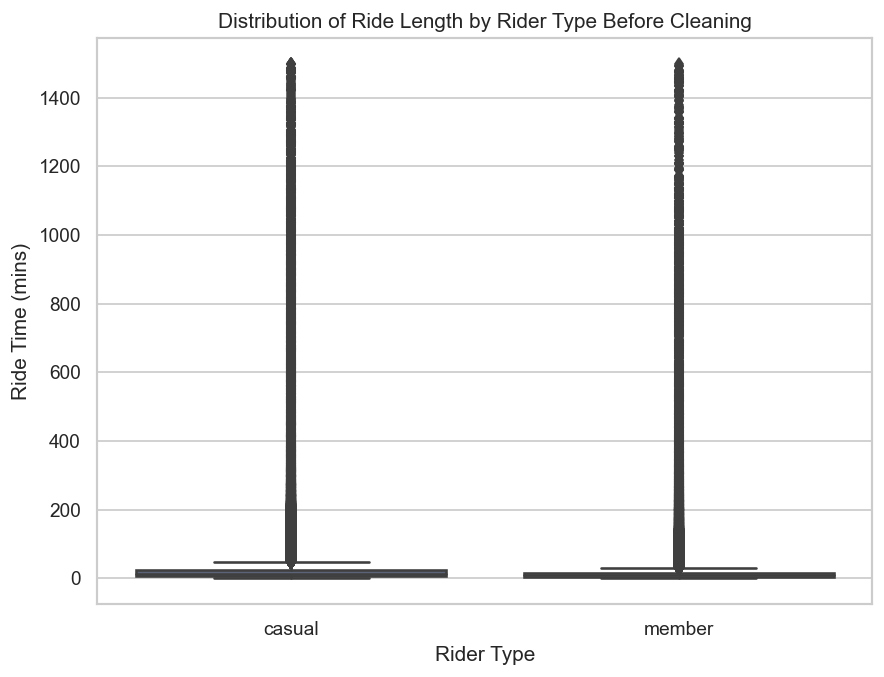

In [16]:
sns.boxplot(data=cleaned, x='member_casual', y='ride_time_mins')
plt.title('Distribution of Ride Length by Rider Type Before Cleaning')
plt.xlabel('Rider Type')
plt.ylabel('Ride Time (mins)')

Wow look at all those outliers living their best life outside the upper IQR bound. This makes the boxplot unusable for looking at the distribution. Let's look at a histogram to see if we can find any useful information.

Text(0, 0.5, 'Number of Rides')

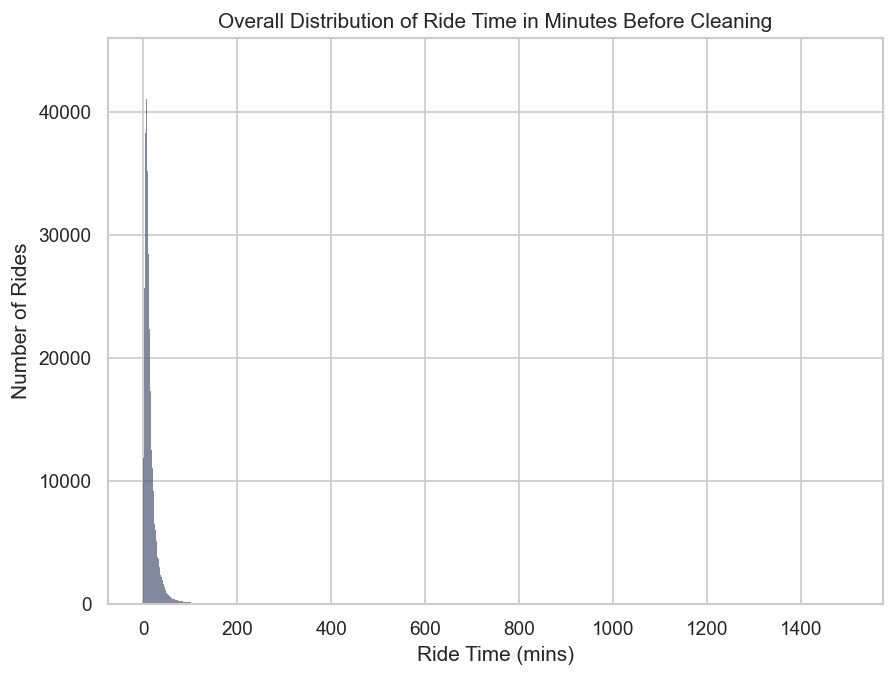

In [17]:
sns.histplot(data=cleaned, x='ride_time_mins')
plt.title('Overall Distribution of Ride Time in Minutes Before Cleaning')
plt.xlabel('Ride Time (mins)')
plt.ylabel('Number of Rides')

Given the extreme skew to the right, we might be able to use winsorization to remove outliers at the 1st and 99th percentiles. Let's calculate those values now to make sure that it make sense.

In [18]:
print(cleaned['ride_time_mins'].quantile(0.99))
print(cleaned['ride_time_mins'].quantile(0.01))

90.5
0.43333333333333335


Looks good. This means that 99% of riders take their bikes out for less than 1.5 hours. We'll miss less than 1% of the riders who actually make use of Divvy's 3-hour day pass, but that's a small price to pay to see how the vast majority (99%) of casual riders use the bikes. 

Let's go ahead and split up our data into 2 groups, members and casuals so that we can clean them separately before recombining them for further analysis.

In [19]:
def clean_by_quantile(df):
    bottom_limit = df['ride_time_mins'].quantile(0.01)
    upper_limit = df['ride_time_mins'].quantile(0.99)

    casual = df[df['member_casual'] == 'casual']
    member = df[df['member_casual'] == 'member']

    holder = []

    for i in [casual, member]:
        i = i[(i['ride_time_mins'] > bottom_limit) & (i['ride_time_mins'] < upper_limit)]
        holder.append(i)

    cleaned = pd.concat(holder)
    return cleaned

In [20]:
cleaned2 = clean_by_quantile(cleaned)

Let's see the fruits of our labor:

Text(0, 0.5, 'Number of Rides')

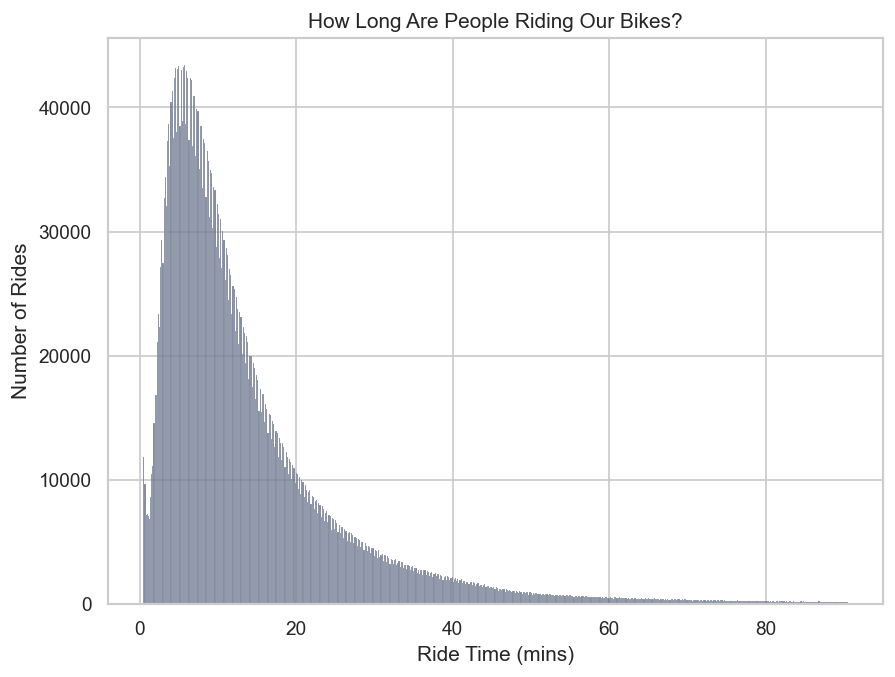

In [21]:
sns.histplot(cleaned2, x='ride_time_mins')
plt.title('How Long Are People Riding Our Bikes?')
plt.xlabel('Ride Time (mins)')
plt.ylabel('Number of Rides')

Text(0, 0.5, 'Ride Time (mins)')

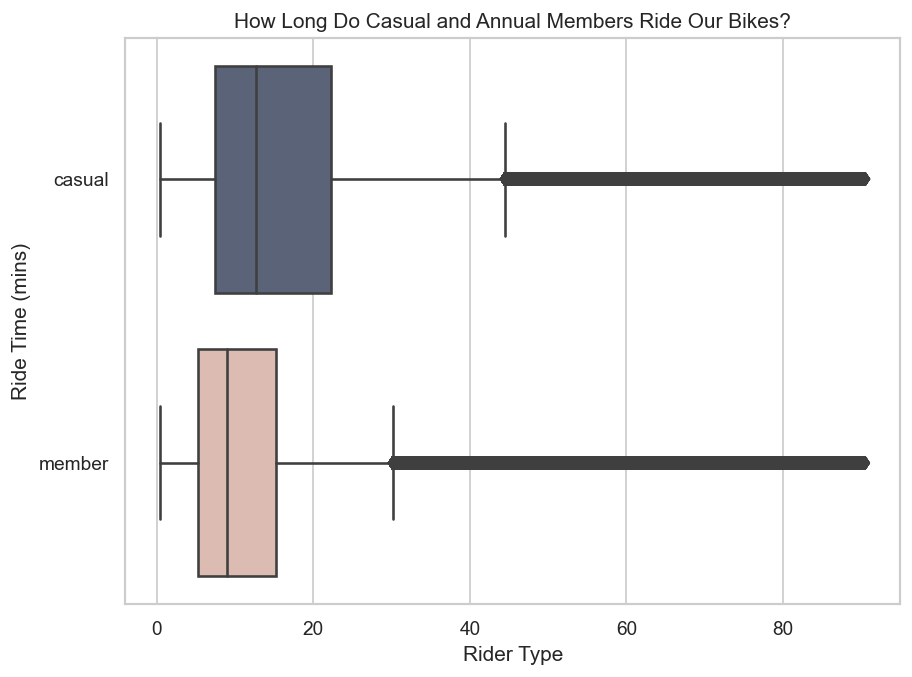

In [22]:
sns.boxplot(data=cleaned2, y='member_casual', x='ride_time_mins')
plt.title('How Long Do Casual and Annual Members Ride Our Bikes?')
plt.xlabel('Rider Type')
plt.ylabel('Ride Time (mins)')

In [23]:
cleaned2.groupby('member_casual')['ride_time_mins'].describe()

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,1560030.0,17.774375,15.676150,0.45,7.466667,12.633333,22.266667,90.483333
member,2693181.0,11.953229,9.940638,0.45,5.300000,8.966667,15.250000,90.483333


Our data is looking much cleaner now and is finally ready for some more analysis.

# Analysis
**The Business Objective:**
Our company wants to launch a campaign to convert current casual riders into paying subscribers. Our job is to find some of the differences between how casual and member riders use their bikes. We will analyze our rider data by looking at the following dimensions:

1. Ride Length
2. Time of day
3. Weekday vs Weekend
4. Locations
5. Seasonality
6. Type of Bike

# Ride Length
## Average Ride Time
The hypothesis for us to test is that there is a statistically significant difference in the average ride time between casual riders and paying members. It seems that casual riders ride for longer - ~18 mins vs ~12 mins. 

In [24]:
cleaned2.groupby('member_casual')['ride_time_mins'].describe()

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,1560030.0,17.774375,15.676150,0.45,7.466667,12.633333,22.266667,90.483333
member,2693181.0,11.953229,9.940638,0.45,5.300000,8.966667,15.250000,90.483333


In [25]:
all_riders = cleaned2
casual = cleaned2[cleaned2['member_casual'] == 'casual']
member = cleaned2[cleaned2['member_casual'] == 'member']

In [26]:
significance = ttest(casual['ride_time_mins'], member['ride_time_mins'], equal_variances=False, paired=False)

In [27]:
significance[0]

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,ride_time_mins,1560030.0,17.774375,15.676150,0.012551,17.749776,17.798975
1,ride_time_mins,2693181.0,11.953229,9.940638,0.006057,11.941357,11.965101
2,combined,4253211.0,14.088360,12.671896,0.006144,14.076317,14.100403


### Conclusion
There is a meaningful difference in ride length between members and casual riders. 

**Casual Riders:** ~18 Min Avg Ride time

**Member Riders:** ~12 Min Avg Ride time

## Long Ride Time Study

Having established that casual riders ride longer on average, let's keep exploring this variable

Text(0, 0.5, 'Rider Type')

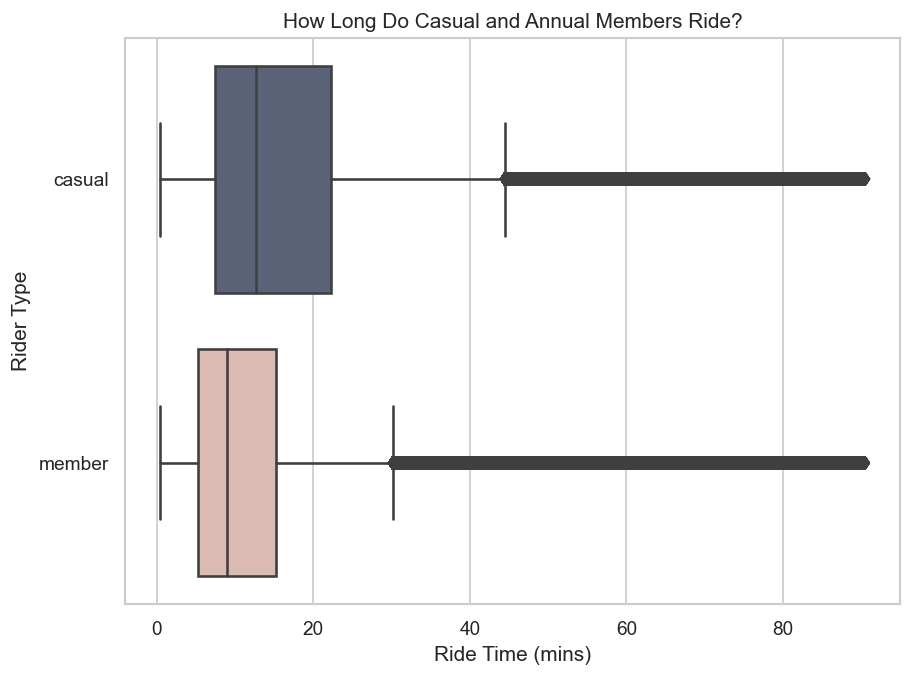

In [28]:
sns.boxplot(data=all_riders, x='ride_time_mins', y='member_casual')
plt.title('How Long Do Casual and Annual Members Ride?')
plt.xlabel('Ride Time (mins)')
plt.ylabel('Rider Type')

The boxplot shows our distribution of ride length by membership type.

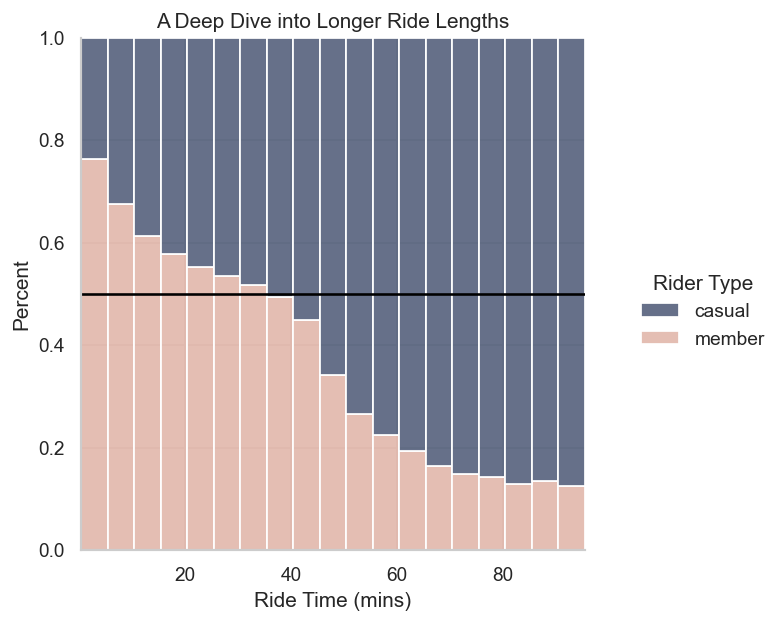

In [29]:
g = sns.displot(data=all_riders, x = 'ride_time_mins', hue='member_casual', multiple='fill', stat='percent', binwidth=5, alpha=0.9)
plt.axhline(0.5, c='black')
plt.title('A Deep Dive into Longer Ride Lengths')
plt.xlabel('Ride Time (mins)')
g.legend.set_title('Rider Type')

As a proportion of total ride time, casual riders start to become the majority of riders after the 40-minute mark.

### Conclusion
Not only do casual riders ride longer on average, they also make up the overwhelming majority of riders who ride for more than 40 minutes. 

## Time of Day
Now, let's analyze our riders by when they start their bike rental. We can categorize them as:
* Overnight (12 AM - 5 AM)
* Early Morning (5 AM - 7 AM)
* Morning (7 AM - 10 AM)
* Mid-Morning (10 AM - 12 PM)
* Afternoon (12 PM - 4 PM)
* Early Evening (4 PM - 7 PM)
* Night (7 PM - 10 PM)
* Late Night (10 PM - 12 AM)

In [30]:
def tod_map(x):
    if 0 <= x < 5:
        return 'Overnight'
    elif 5 <= x < 7:
        return 'Early Morning'
    elif 7 <= x < 10:
        return 'Morning'
    elif 10 <= x < 12:
        return 'Mid-Morning'
    elif 12 <= x < 16:
        return 'Afternoon'
    elif 16 <= x < 19:
        return 'Early Evening'
    elif 19 <= x < 22:
        return 'Night'
    elif 22 <= x < 24:
        return 'Late Night'
    else:
        return 'Check Hour'


In [31]:
all_riders['hour_started'] = all_riders['started_at'].dt.hour 
all_riders['hour_started'].value_counts(normalize=True)

17    0.104281
16    0.088149
18    0.085955
15    0.069377
19    0.062586
14    0.058732
13    0.057610
12    0.057412
8     0.052716
11    0.049221
20    0.044094
7     0.043639
10    0.039801
9     0.038913
21    0.035677
22    0.028893
6     0.023497
23    0.019668
0     0.013199
1     0.008265
5     0.008238
2     0.004794
3     0.002784
4     0.002499
Name: hour_started, dtype: float64

It's always a good idea to get a sense of the data before going forward with any other visualizations. Normalize helps translate the count into percentages and complements the histogram below.

Text(0.5, 15.555555555555548, 'Start Time (24H format)')

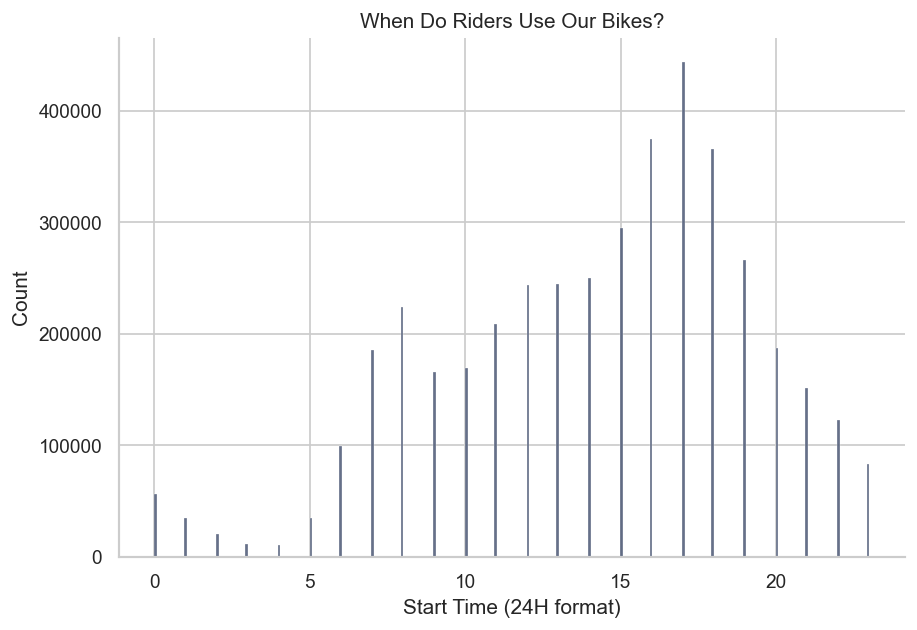

In [32]:
sns.displot(data=all_riders, x='hour_started', kind='hist', alpha=0.9, aspect=1.5)
plt.title('When Do Riders Use Our Bikes?')
plt.xlabel('Start Time (24H format)')

From this intial distribution, it looks like the majority of riders are taking their bikes out after 3 PM. We should take a closer look and split up the distribution by rider type.

In [33]:
all_riders['time_of_day'] = pd.Categorical(all_riders['hour_started'].map(tod_map), ['Overnight', 'Early Morning', 'Morning', 
                                                                                     'Mid-Morning', 'Afternoon', 'Early Evening',
                                                                                     'Night', 'Late Night'])

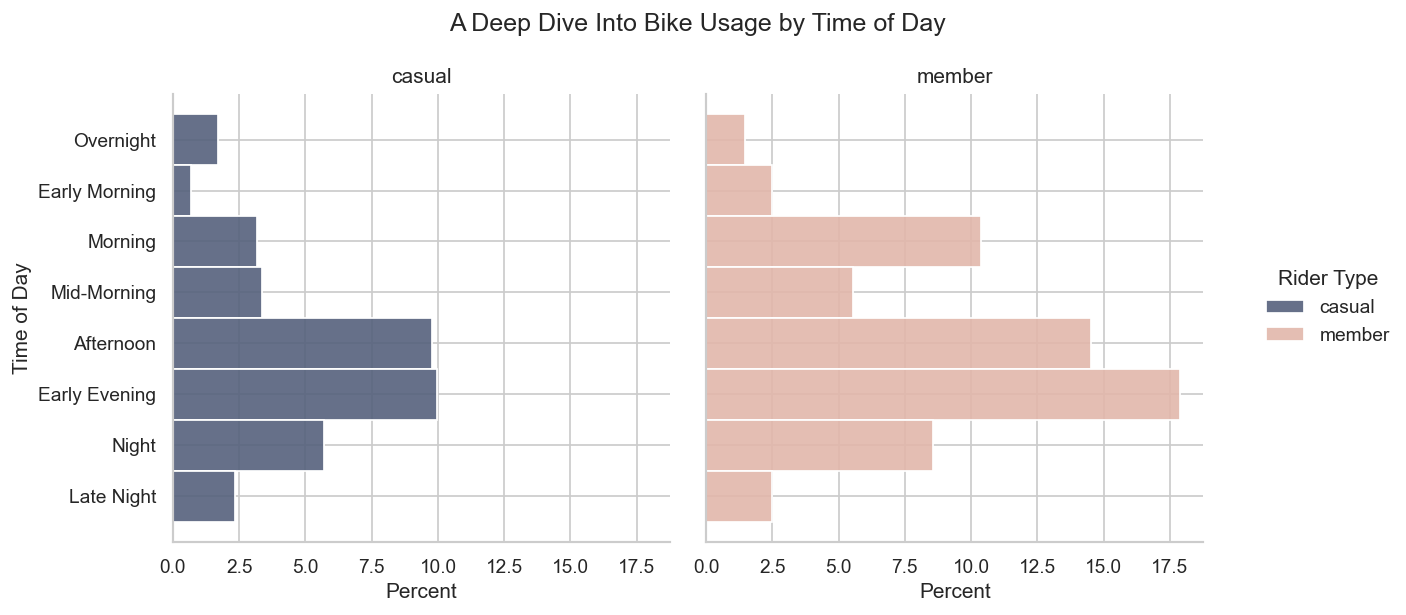

In [34]:
g = sns.displot(data=all_riders, y='time_of_day', col='member_casual', hue='member_casual', stat='percent', alpha=0.9)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('A Deep Dive Into Bike Usage by Time of Day')
g.legend.set_title('Rider Type')
g.set_ylabels('Time of Day')
g.set_titles(col_template='{col_name}')

Our annual members tend to ride their bikes in the Morning (7 AM - 10 AM) and from the Afternoon (12 PM - 4 PM) into the Early Evening (4 PM - 7 PM). This suggests that our annual members use their bikes more frequently during commuting hours to and from work. The spikes in usage are parallel with 9 AM and 5 PM rush hour traffic.

Our casual riders are not as active in the morning, with most of them taking rides in the Afternoon and Early Evening. Unlike our annual members, they casual riders do not have a Morning (7 AM - 10 AM) spike.

### Conclusion
Our annual members are probably using their bikes during commuting hours to get to and from work whereas casual members are the most active from 12PM - 7PM. This may suggest that casual riders are typically not using our bikes for their commute.

## Weekday vs Weekend Riders

Having examined the time of day, let's look at how riders are using our bikes throughout the week.

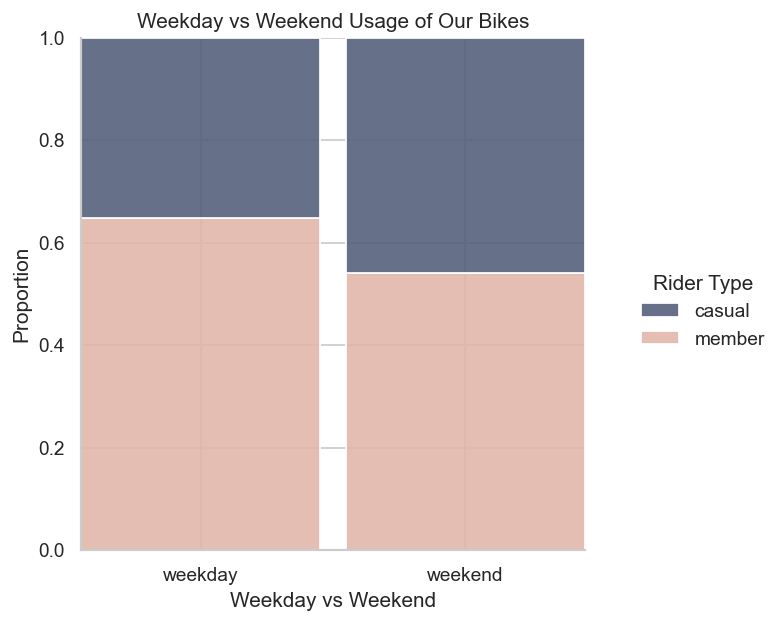

In [35]:
g = sns.displot(data=all_riders, x = 'weekday_weekend', hue='member_casual', multiple='fill', 
            stat='proportion', shrink=0.9, alpha=0.9)
plt.title("Weekday vs Weekend Usage of Our Bikes")
plt.xlabel('Weekday vs Weekend')
g.legend.set_title('Rider Type')

Casual riders have come out more frequently on the weekends to ride our bikes. Let's take a look day-by-day.

In [36]:
all_riders['day_of_week'] = pd.Categorical(all_riders['started_at'].dt.day_name(), ['Monday', 'Tuesday', 'Wednesday', 
                                                                                    'Thursday', 'Friday', 'Saturday', 'Sunday'])

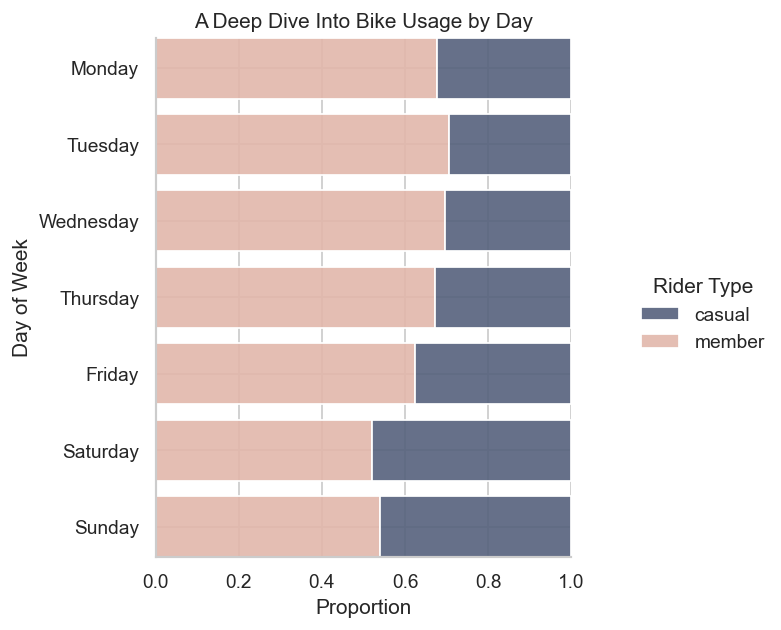

In [37]:
g = sns.displot(data=all_riders, y='day_of_week', hue='member_casual', multiple='fill', stat='proportion', shrink=0.8, alpha=0.9)
plt.title('A Deep Dive Into Bike Usage by Day')
plt.ylabel('Day of Week')
g.legend.set_title('Rider Type')

We see more casual riders using our bikes on Saturday and Sunday than any other day of the week.

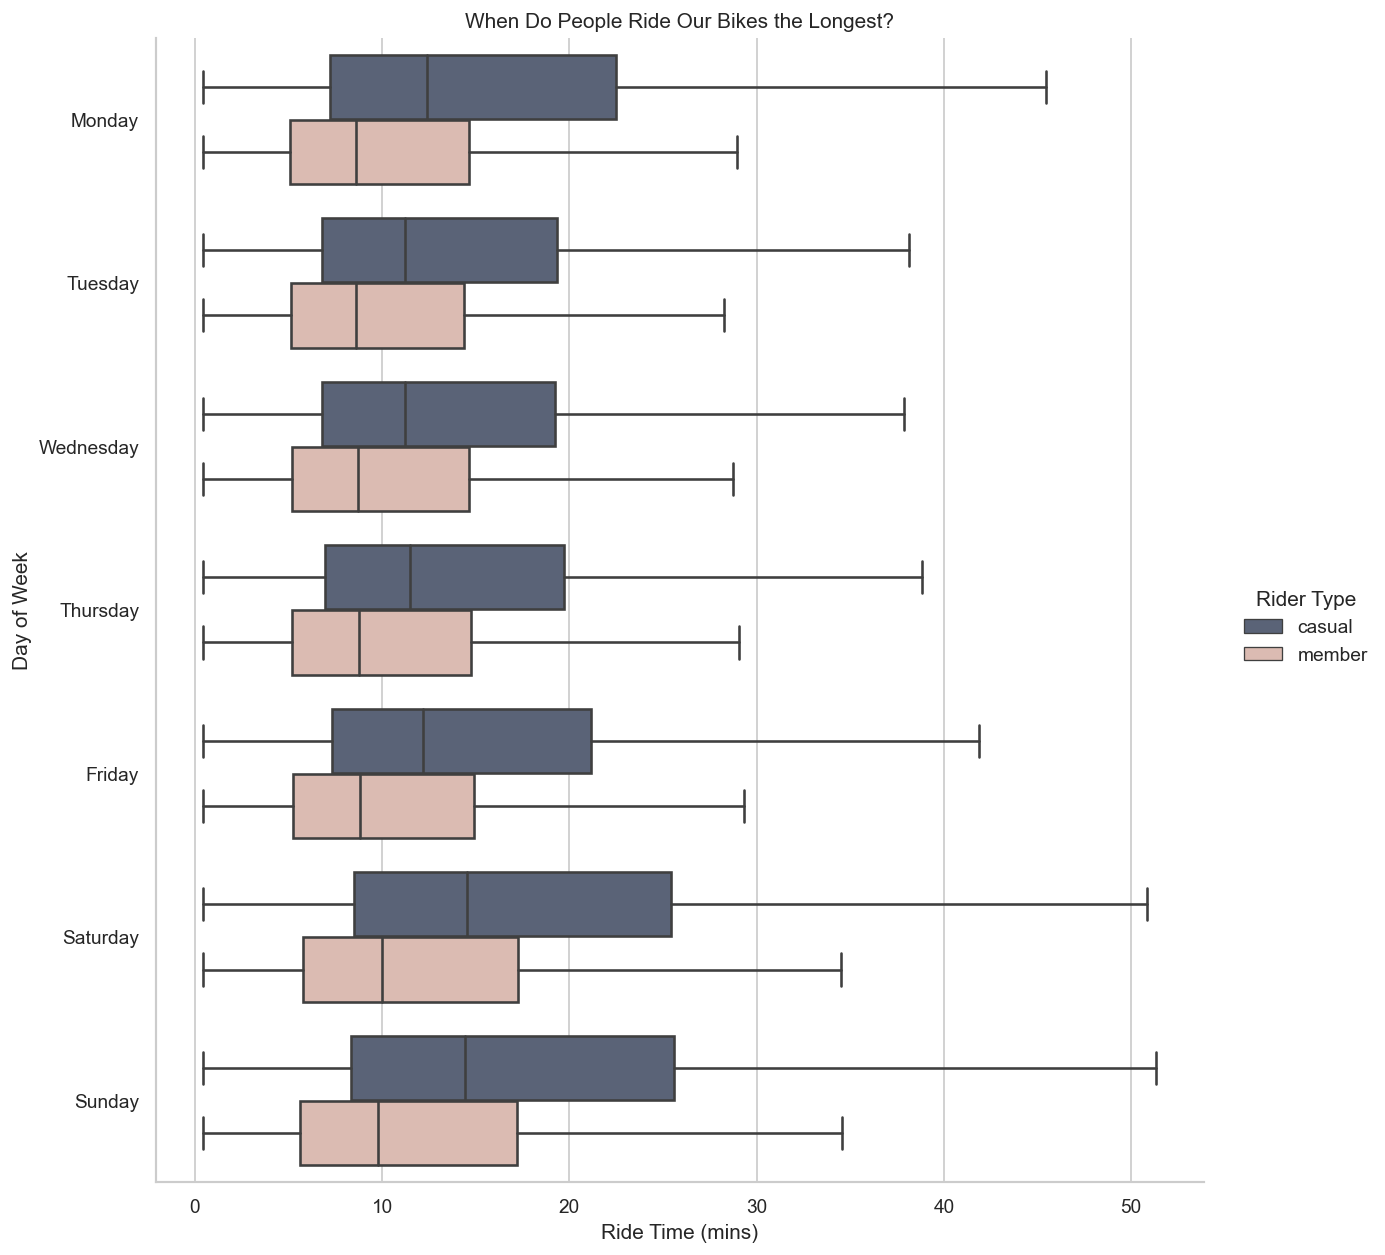

In [38]:
g = sns.catplot(data=all_riders, x='ride_time_mins', hue='member_casual', y='day_of_week', kind='box', showfliers=False, height=10)
plt.title('When Do People Ride Our Bikes the Longest?')
plt.ylabel('Day of Week')
plt.xlabel('Ride Time (mins)')
g.legend.set_title('Rider Type')

### Conclusion
Casual riders tend to ride for significantly longer than our member riders across the board, especially on the weekends. There are also more casual riders on the weekends vs the weekdays.

# Location, Location, Location
## Popular Stations
Is there a difference in where our casual and annual member start and end their rides? Let's take a look at the top 30 stations overall and by each kind of rider.

In [39]:
top_30_stations = pd.crosstab(index=all_riders['start_station_name'], columns='count').sort_values(by='count', ascending=False).head(30)

Text(0, 0.5, 'Starting Station Name')

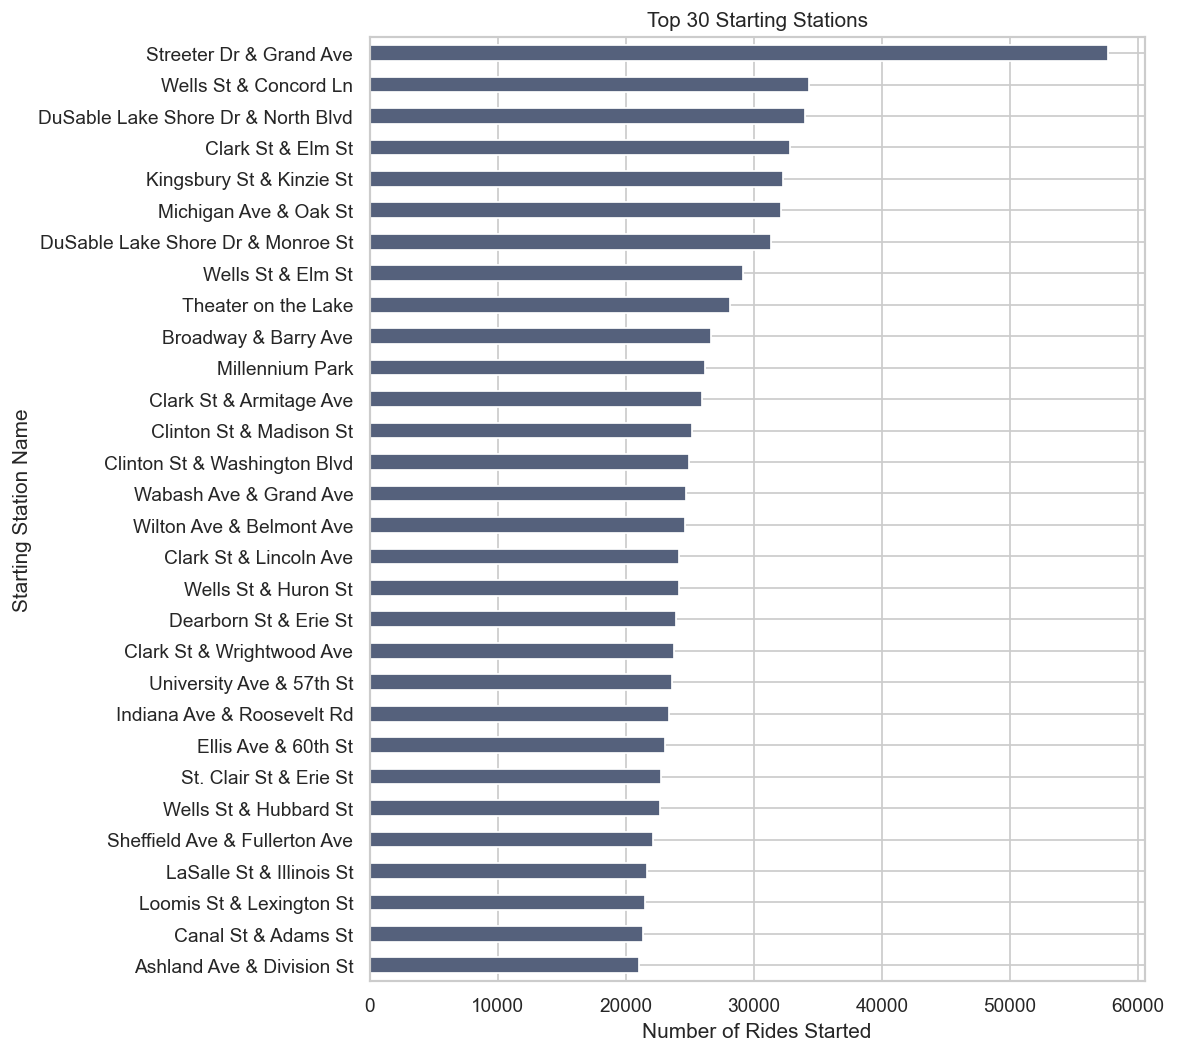

In [40]:
top_30_stations.plot(kind='barh', legend=None, ylabel=None, figsize=(8,10)).invert_yaxis()
plt.title('Top 30 Starting Stations')
plt.xlabel('Number of Rides Started')
plt.ylabel('Starting Station Name')

The most popular starting destination for our bike ride is Streeter Dr. and Grand Ave. This is right by the Navy Pier and the Centennial Wheel. Many of these other popular starting destinations are also right along the water, such as DuSable and Monroe. Our second most popular starting point is on Wells St and Concord Ln, right by Lincoln Park.

Let's break down our top 30 locations by casual vs annual membership riders and see if we can gain more insight into the data:

Text(0.5, 1.0, 'Top 30 Starting Stations by Rider Type')

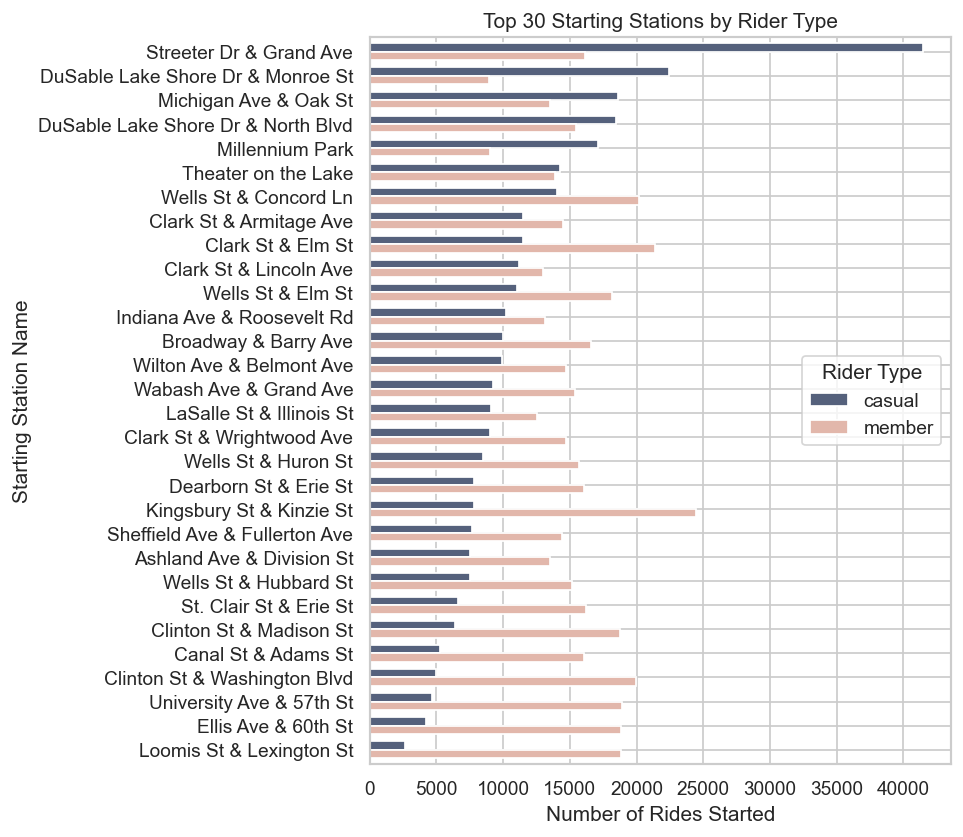

In [41]:
def filter_top_30(df):
    df = df[df['start_station_name'].isin(top_30_stations.index)]
    return df

x = filter_top_30(all_riders)
tab = pd.crosstab(index=x['start_station_name'], columns=x['member_casual'])
tab.sort_values(by='casual', inplace=True, ascending=False)

tab.plot.barh(align='center', width=0.7, figsize=(6,7.7)).invert_yaxis()
plt.legend(loc='center right')
plt.ylabel('Starting Station Name')
plt.xlabel('Number of Rides Started')
plt.legend(title='Rider Type', loc='center right')
plt.title('Top 30 Starting Stations by Rider Type')

In the graph above, we sorted our top 30 starting stations by the popularity with our casual riders. The top 5 starting stations are all tourism/recreation locations:

* The Navy Pier
* Lake Shore Drive
* Millennium Park
* Michigan Ave
* Theater on the Lake

The locations where our annual members outnumber our casual riders tend to be more inland and closer to the businesses and residential areas of the city.

## Conclusion
Casual riders tend to start riding our bikes near the Navy Pier or along the water and recreation areas lining Lake Shore Drive. Our annual members tend to start their rides around businesses and residential neighborhoods.

# Seasonality
Let's look at the seasonality of our data to see if there are any differences in riding behavior throughout the year between our casual and annual members.

In [42]:
all_riders['month_year'] = all_riders['started_at'].dt.strftime('%b %Y')

In [43]:
all_riders.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,ride_time_mins,year,month,day_of_week,weekday_weekend,hour_started,time_of_day,month_year
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,...,-87.674367,casual,2.950000,2022,1,Thursday,weekday,11,Mid-Morning,Jan 2022
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,...,-87.674367,casual,4.350000,2022,1,Monday,weekday,8,Morning,Jan 2022
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,...,-87.671387,casual,14.933333,2022,1,Tuesday,weekday,0,Overnight,Jan 2022
14,E119D4E6BF686601,electric_bike,2022-01-08 05:36:40,2022-01-08 05:46:40,Michigan Ave & Jackson Blvd,TA1309000002,St. Clair St & Erie St,13016,41.877849,-87.624056,...,-87.622798,casual,10.000000,2022,1,Saturday,weekday,5,Early Morning,Jan 2022
22,9D4AAF43A011FC59,electric_bike,2022-01-18 08:03:16,2022-01-18 08:08:00,California Ave & Altgeld St,15646,Milwaukee Ave & Rockwell St,13242,41.926648,-87.697661,...,-87.692659,casual,4.733333,2022,1,Tuesday,weekday,8,Morning,Jan 2022


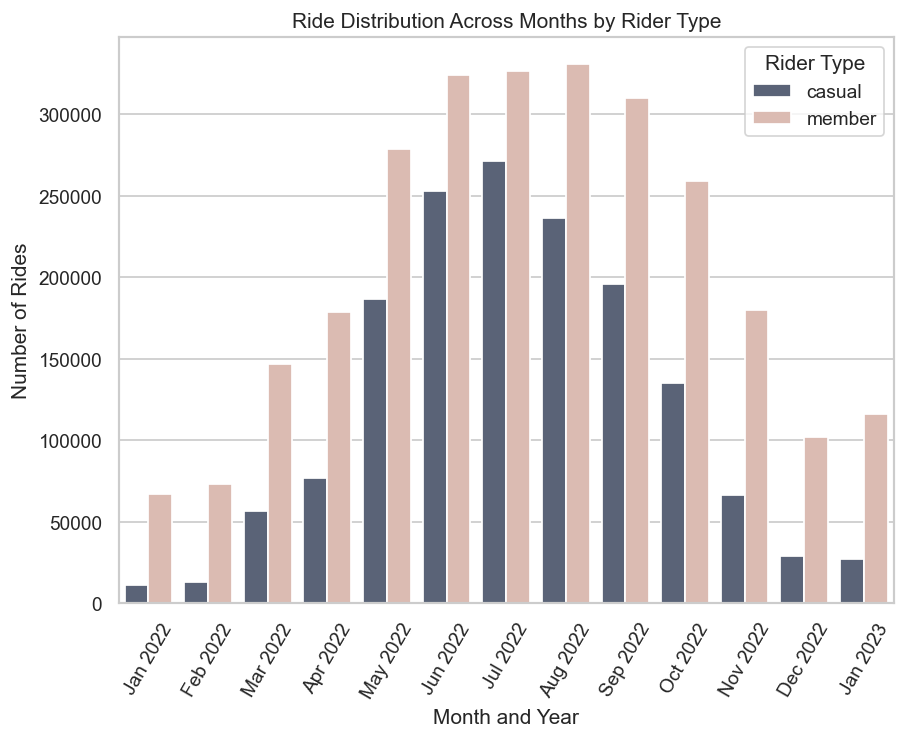

In [44]:
g = sns.countplot(data=all_riders, x='month_year', hue='member_casual')
plt.xticks(rotation=60)
plt.title('Ride Distribution Across Months by Rider Type')
plt.ylabel('Number of Rides')
plt.xlabel('Month and Year')
plt.legend(title='Rider Type')

From the above chart, we can notice a few things:
* Casual riders are barely out during the colder months of Dec - Feb. They start picking up again in March.
* There's a normal distribution across both kinds of riders, with casual riders increasing dramatically in May and peaking in July. Our member riders are more consistently riding throughout the warmer months whereas our causal riders drop off more quickly after August.

## Conclusion
There is a significant drop off in casual riders during the colder months. They tend to start riding more actively in May, peak in July, and drop off sharply again by October.

Our casual riders are more consistently riding year-round, especially throughout the late Summer and into early Fall.

# Type of Bike by Ridership
We have 2 kinds of bikes available: classic and electric bikes. Let's see how they're being used:

In [45]:
sns.set_palette(sns.color_palette(['#3B9B93', '#9ACBF9']))

In [46]:
all_riders['rideable_type'] = all_riders['rideable_type'].astype('category')
all_riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4253211 entries, 0 to 5858014
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   start_station_id    category      
 6   end_station_name    category      
 7   end_station_id      category      
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  ride_time_mins      float64       
 14  year                int64         
 15  month               int64         
 16  day_of_week         category      
 17  weekday_weekend     category      
 18  hour_started        int64         
 19  time_of_day         category      
 20  mo

Text(15.555555555555541, 0.5, 'Ride Count (Millions)')

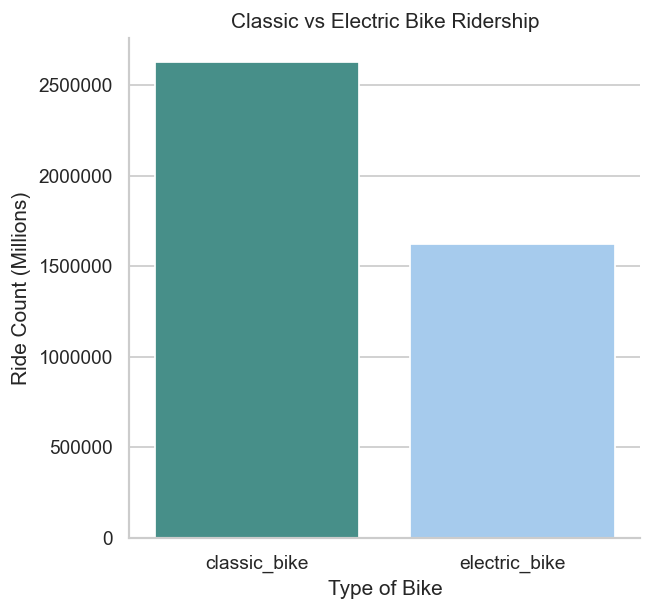

In [49]:
sns.catplot(data=all_riders, kind='count', x='rideable_type')
plt.title('Classic vs Electric Bike Ridership')
plt.xlabel('Type of Bike')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Ride Count (Millions)')

Classic bikes are still the most popular kind of bike. Let's see how usage break down between our casual and annual members.

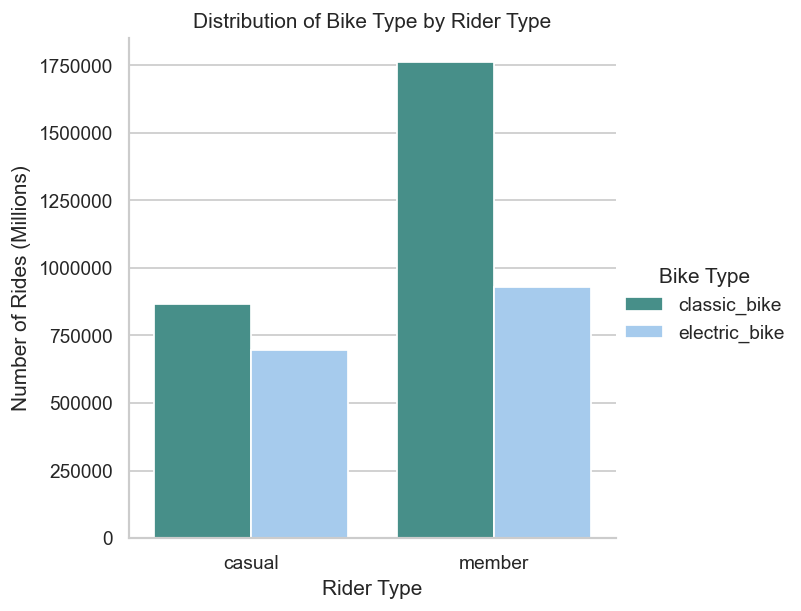

In [50]:
g = sns.catplot(data=all_riders, kind='count', hue='rideable_type', x='member_casual')
plt.title('Distribution of Bike Type by Rider Type')
plt.ylabel('Number of Rides (Millions)')
plt.xlabel('Rider Type')
plt.ticklabel_format(style='plain', axis='y')
g.legend.set_title('Bike Type')

It looks like classic bikes are way more popular among our annual members, and only slightly more popular among our casual riders.

## Conclusion
Our annual members tend to ride classic bikes over electric bike. Casual users tend to ride more classic bikes, but not by a significant amount.